In [1]:
import sys
sys.path.append('../')
from xd import *
from utils import *
import esutil
import healpy as hp
from systematics import *
from systematics_module import *
from run_systematics import calling_sysMap, maskingCatalogSP
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
def ks_test( sample1, sample2, tag = '', label = ['1', '2'], bins=None, outdir = './' ):
    from scipy import stats
    #bins = np.linspace(100, 110, 100)

    fig, (ax,ax2) = plt.subplots(2,1,figsize=(5,7))
    N1, _, _= ax.hist(sample1, bins = bins, normed=True, label = label[0]  )
    N2, _, _= ax.hist(sample2, bins = bins,normed=True, alpha = 0.7, label=label[1]  )
    ax.set_xlabel(tag)
    ax.set_ylabel('N')
    
    CN1 = np.array([ np.sum(N1[0:i]) for i in range(1, len(N1)+1) ])
    CN2 = np.array([ np.sum(N2[0:i]) for i in range(1, len(N2)+1) ])

    D, p_value = stats.ks_2samp(sample1, sample2)
    
    #fig, ax = plt.subplots()
    ax2.plot(bins[:-1], CN1*1./CN1[-1])
    ax2.plot(bins[:-1], CN2*1./CN2[-1])
    ax2.set_xlabel(tag)
    ax2.set_ylabel('Cumulative Probability')
    ax2.text(bins[0], 0.8, 'D = {:0.3e}\np_value = {:0.5f}\n'.format(D, p_value*100) )
    ax.legend(loc='best')
    fig.savefig(outdir + 'kstest.png')


In [3]:
def brelchisqr(xi, xi2, invcov, brelsqr):
    DiffVector = xi2 - brelsqr*xi
    chi2 = np.dot( np.dot( DiffVector , invcov), DiffVector )
    return chi2

def find_nearest(array, value, brell):
    
    ind_min = array.argmin()
    array1 = np.asarray(array[:ind_min])
    idx1 = (np.abs(array1 - value)).argmin()
    
    array2 = np.asarray(array[ind_min:])
    idx2 = (np.abs(array2 - value)).argmin()
    
    return brell[:ind_min][idx1], brell[ind_min], brell[ind_min:][idx2]


def brel_chisqr_fitting(xi1, xi2, Fisher, verbose=False):
    
    brelsqr = np.linspace(0.8, 1.2, 5000)   
    brelarr = np.sqrt(brelsqr) 
    chisqr_result = np.zeros(brelsqr.size)
    
    i=0
    for b in brelsqr:
        chisqr_result[i] = brelchisqr(xi1, xi2, Fisher, b)
        i+=1   
        
    minarg = chisqr_result.argmin()
    chisqr_min = chisqr_result.min()
    brel = np.sqrt(brelsqr[minarg])
    
    b_cmass = 2.0
    db = b_cmass * (1. - 1./brel)
    
       
    b_cmass = 2.0

    br1, brmin, br2 = find_nearest( chisqr_result, chisqr_min + 1,brelarr )
    err_brel = np.abs(br1-br2)/2.
    err_db = err_brel *b_cmass
    if verbose : print 'err db, db / br1, brmin, br2 :', err_db, db, br1, brmin, br2  
    #return err_db, db, chisqr_result
    return err_brel, brmin, chisqr_result
    

In [7]:
rootdir = '../output/slr_train_photo_SamPle_ran100/'
inputdir = rootdir
figoutdir = inputdir+'/figure/'
sysoutdir = inputdir+'/sys/'
basedir = inputdir+'/act/'
os.system('mkdir '+inputdir)
os.system('mkdir '+figoutdir)
os.system('mkdir '+inputdir+'/weights/')
os.system('mkdir '+basedir)
#os.system('cp ../data_txt/systematics/4th/systematic*_no_weight.txt '+inputdir+'/.')

0

In [5]:
# calling map 
GoldMask = callingEliGoldMask()
#GoldMask_st82 = Cuts.SpatialCuts(GoldMask, ra=320, ra2=360, dec=-2, dec2=2)
GoldMask_st82 = GoldMask[ GoldMask['DEC'] > -3.0 ]
GoldMask_spt = GoldMask[ GoldMask['DEC'] < -3.0 ]
#GoldMask_spt = cutcat20(GoldMask_spt)
#GoldMask_spt = Cuts.SpatialCuts(GoldMask_spt, ra=0, ra2 = 100, dec=-52, dec2 = -48)

pixarea = hp.nside2pixarea( 4096, degrees = True)
sptnpix = GoldMask_spt['PIXEL'].size #hp.get_map_size( GoldMask_spt['PIXEL'] )
st82npix =  GoldMask_st82['PIXEL'].size # hp.get_map_size( GoldMask_st82 )
SPTMaparea = pixarea * sptnpix
ST82Maparea = pixarea * st82npix

In [8]:
# import DMASS


#dmass = fitsio.read(rootdir+'dmass_spt_0001.fits')
#dmass = fitsio.read('../output/sampling_atonce/dmass_spt_0002.fits')
#dmass = fitsio.read('../output/mock/dmass_spt_0001.fits')
dmass_st82 = fitsio.read(rootdir+'dmass_st82_0001.fits')
#dmass = cutcat20(dmass)

#cmass_sgc = fitsio.read('/n/des/lee.5922/data/cmass_cat/galaxy_DR11v1_CMASS_South.fits.gz')
#rand_sgc = fitsio.read('/n/des/lee.5922/data/cmass_cat/random0_DR12v5_CMASS_South.fits.gz')

#cmass_sgc = fitsio.read('/n/des/lee.5922/data/cmass_cat/cmass-dr12v4-S-Reid-full.dat.fits')
rand_sgc = fitsio.read('/n/des/lee.5922/data/cmass_cat/random0_DR12v5_CMASS_South.fits.gz')


#rand_sgc2 = fitsio.read('/n/des/lee.5922/data/cmass_cat/random1_DR12v5_CMASS_South.fits.gz')
#cmass = Cuts.keepGoodRegion(cmass_sgc)
#train = fitsio.read(rootdir+'train_sample_des.fits')
train = fitsio.read(rootdir+'train_sample_des.fits')
cmass = fitsio.read(rootdir+'cmass_in_st82.fits')
rand2_cmass = Cuts.keepGoodRegion(rand_sgc)
#cmass = fitsio.read('../output/ge_low/train_sample_des.fits')
print 'dmass sample size :', dmass.size
print 'dmass sample size :', dmass_st82.size
print 'cmass sample size :', cmass.size
print 'train sample size :', train.size

#cmass_weight = cmass['WEIGHT_FKP'] * cmass['WEIGHT_SYSTOT'] * ( cmass['WEIGHT_CP'] + cmass['WEIGHT_NOZ'] -1.)
#cmass = appendColumn(cmass, name = 'WEIGHT', value = cmass_weight)
#rand2_cmass = appendColumn(rand2_cmass, name = 'WEIGHT_RAND', value = rand2_cmass['WEIGHT_FKP'])

dmass sample size :

NameError: name 'dmass' is not defined

In [10]:
#rand_bg = uniform_random_on_sphere(dmass_spt2, size = 100 * dmass_spt2.size)
#rand_bg = Cuts.keepGoodRegion(rand_bg)
#rand_bg_train = uniform_random_on_sphere(clean_cmass_data_des, size = 100 * clean_cmass_data_des.size)
#rand_bg_train = Cuts.keepGoodRegion(rand_bg_train)

rand = uniform_random_on_sphere(dmass, size = 10 * dmass.size)
rand = Cuts.keepGoodRegion(rand)
#rand = Cuts.keepY1GoldRegion(rand)
rand = rand[ rand['DEC'] < -3.0 ]
#rand = cutcat20(rand)

rand2 = uniform_random_on_sphere(dmass, size = 50 * dmass.size)
rand2 = Cuts.keepGoodRegion(rand2)
#rand = Cuts.keepY1GoldRegion(rand)
rand2 = rand2[ rand2['DEC'] < -3.0 ]
#rand2 = cutcat20(rand2)

rand_dmass_st82 = uniform_random_on_sphere(cmass, size = 200 * cmass.size)
rand_dmass_st82 = Cuts.keepGoodRegion(rand_dmass_st82)
rand_dmass_st82 = rand_dmass_st82[ rand_dmass_st82['DEC'] > -3.0 ]
rand_cmass = rand_dmass_st82.copy()

rand2_dmass_st82 = uniform_random_on_sphere(cmass, size = 500 * cmass.size)
rand2_dmass_st82 = Cuts.keepGoodRegion(rand2_dmass_st82)
rand2_dmass_st82 = rand2_dmass_st82[ rand2_dmass_st82['DEC'] > -3.0 ]

print rand.size, dmass.size
#print rand_cmass.size, cmass.size
#rand_train = uniform_random_on_sphere(clean_cmass_data_des, size = 10 * clean_cmass_data_des.size)
#rand_train = Cuts.keepGoodRegion(rand_train)

0 13318


writing output plot to: ../output/slr_train_photo_SamPle_ran100//figure//st82_diagnostic_histograms_1d.png


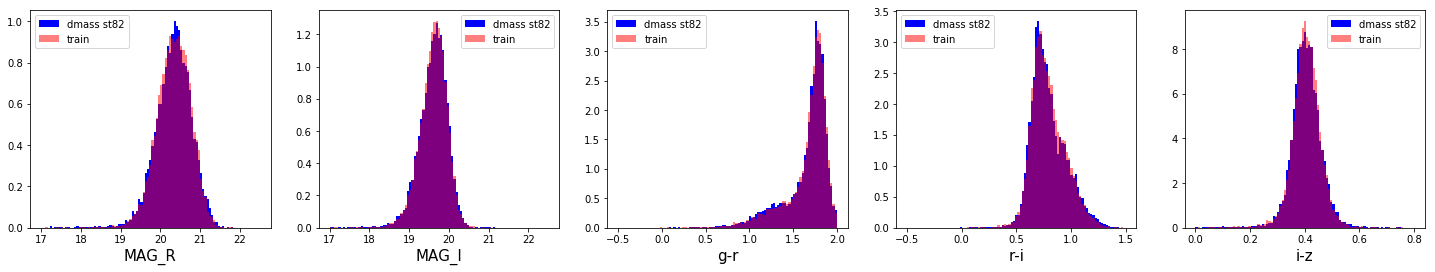

In [12]:
# Plotting all
labels = ['MAG_R', 'MAG_I', 'g-r', 'r-i', 'i-z']
ranges =  [[17,22.5], [17,22.5], [-0.5,2], [-0.5,1.5], [0.0,0.8]] 

X_train, Xcov_train = mixing_color(train, no_zband=False)
X_test,_ = mixing_color(dmass_st82, no_zband=False)
doVisualization_1d( X_train, X_test, labels = labels, ranges = ranges,\
                    name =['train','dmass st82' ], nbins=100, prefix='st82_', outdir=figoutdir)

writing output plot to: ../output/sfd_train_photo_SamPle_full3_probcut005//figure//spt_diagnostic_histograms_1d.png


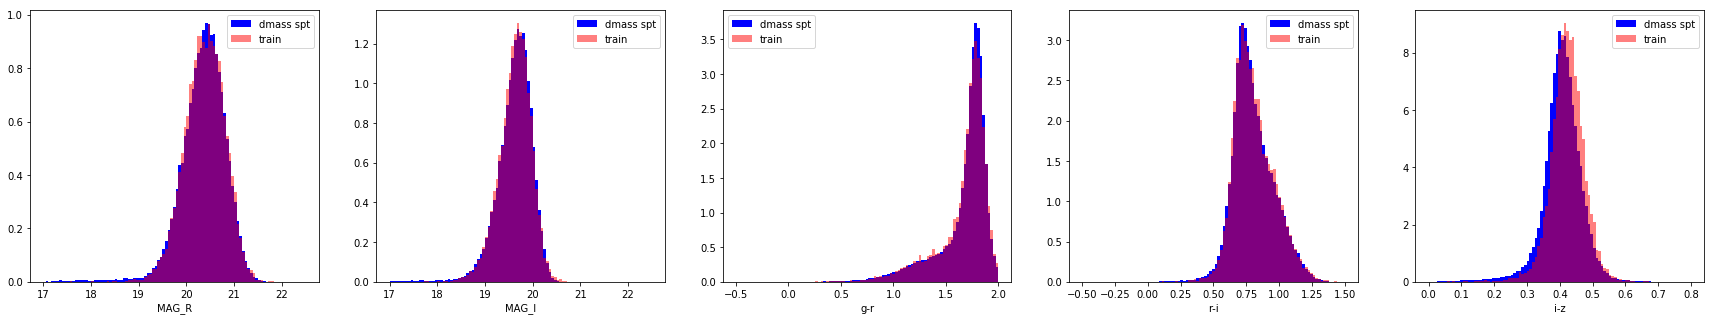

In [45]:
# Plotting all
labels = ['MAG_R', 'MAG_I', 'g-r', 'r-i', 'i-z']
ranges =  [[17,22.5], [17,22.5], [-0.5,2], [-0.5,1.5], [0.0,0.8]] 

X_train, Xcov_train = mixing_color(train)
X_test,_ = mixing_color(dmass)
doVisualization_1d( X_train, X_test, labels = labels, ranges = ranges,\
                    name =['train','dmass spt' ], nbins=100, prefix='spt_', outdir = figoutdir)

In [46]:
#tree corr
from systematics_module.corr import angular_correlation
angular_correlation(data = train, rand = rand2_cmass, nbins=10, njack = 100, 
                    suffix = '_train_nbins10_jk100', dir = basedir)
angular_correlation(data = dmass_st82, rand = rand2_dmass_st82, nbins=10, njack = 100, 
                    suffix = '_dmass_st82_nbins10_jk100', dir = basedir)
angular_correlation(data = dmass, rand = rand2, nbins=10, njack = 100, 
                    suffix = '_dmass_spt_nbins10_jk100', dir = basedir)

calculate angular correlation function
X (1000, 2)  centers (100, 2)  tol=1e-05  maxiter=200
10 iterations  cluster sizes: [ 3  8  6  9  8 10  4 16  7 10 18  8  7  5 11 18  9  7  2  7 25  8 12 11
  3  8  8  6  7 14  8  3  3  6 12 18 12 20  5 10  8 13  1 14  9  8 15  9
  7  0  4 21 15  8  7 13 12 11  2  6  9 16  8  1  8  8  7 12 11 11 18 12
  8 13 18  9  7 15 11 11  6 13 14 11  7 27  7 13  5 11  6  9  8 16 16 18
 12 19  4 10]
X (12639, 2)  centers (100, 2)  tol=1e-05  maxiter=200
42 iterations  cluster sizes: [ 53 119  92 114 152 150 108 128 124 120 174 101  89  81 133 106 132 108
  41  99 186 136 111 126  50  77  99 127 165 217  80  65 108 118 150 136
 152 157 115 136 229 153  75 127  94 135 246 102  64 106  77 206 203  86
 114 141 106 167  66  59 113 196 135  51 115 104  93 112 127 178 132 198
 133 155 150 131  98 157 164 119  63 113 138 132 109 206 144 134 112 110
  79  81 226 153 188 136 116 162  76 209]
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

pic save to  ../output/sfd_train_photo_SamPle_full2///figure/acorr.png


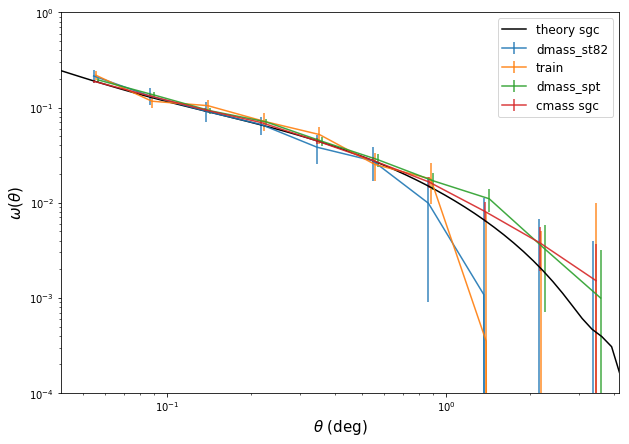

In [78]:
nbins = 10
n_jk = 100

theta_th, theory = np.loadtxt('../data_txt/acf_cmass_ngc_theory.txt', unpack=True)
theta_th, theory_sgc = np.loadtxt('../data_txt/acf_cmass_sgc_theory.txt', unpack=True)

#_, theory_bias = np.loadtxt('../data_txt/acf_cmass_sgc_theory_bias.txt', unpack=True)

#theory_interp = scipy.interpolate.interp1d(theta_th, theory)
#theory_interp = theory_interp(meanr)
#theory_sgc_interp = scipy.interpolate.interp1d(theta_th, theory_sgc)
#theory_sgc_interp = theory_sgc_interp(meanr)

fig, ax = plt.subplots(figsize = (10, 7))
for i, name in enumerate( [ 'dmass_st82', 'train','dmass_spt']):
    
    filename = basedir+ 'acf_auto_'+name+'_nbins{}_jk{}.txt'.format(nbins, n_jk)
    covname = basedir+ 'acf_auto_'+name+'_nbins{}_jk{}.cov'.format(nbins, n_jk)
    meanrw, xiw, xi_errw = np.loadtxt( filename, unpack=True)
    cov_dmass_w = np.loadtxt( covname, unpack=True)
    HFd = HF(n_jk, nbins)
    F_d = HFd * np.linalg.inv(cov_dmass_w)
    #err_brelw, brelw, chisqr_resultw = brel_chisqr_fitting(xiw, theory_sgc_interp(meanrw), F_d, verbose=True)
    ax.errorbar(meanrw*(1+0.02*i), xiw, yerr = xi_errw, fmt = '-', alpha=0.9, label=name )

    
meanr_sgc, xi_sgc, xi_err_sgc = np.loadtxt('../data_txt//acf_auto_cmass_sgc_sys_cp_nz_weight_nbins10_jk100.txt',unpack=True)
cov_cmass_s = np.genfromtxt('../data_txt//acf_auto_cmass_sgc_sys_cp_nz_weight_nbins10_jk100.cov')
ax.errorbar(meanr_sgc, xi_sgc, yerr = xi_err_sgc, fmt = '-', alpha=0.9, label='cmass sgc' )


ax.plot(theta_th, theory_sgc, '-', color='k', label='theory sgc')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(loc = 'best', fontsize = 12)
#ax.text(1.5, 0.07, r'$\chi^2 $ = {:0.3f}  (south)'.format(chisqr), fontsize = 12)
ax.set_ylim(1e-4,1)
ax.set_xlim(2.5/60, 250./60)
ax.set_xlabel(r'$\theta$ (deg)', fontsize = 15)
ax.set_ylabel(r'$\omega(\theta)$', fontsize = 15)

fig.savefig(figoutdir + 'acorr.png')
print 'pic save to ', figoutdir + 'acorr.png'

err db, db / br1, brmin, br2 : 0.11059778724523595 -0.0324178199077485 0.9271957389827012 0.9840496281865803 1.0377935262279372
err db, db / br1, brmin, br2 : 0.09054269601910059 -0.016730930229279295 0.9453987284480291 0.9917039353249879 1.0359414244671297
err db, db / br1, brmin, br2 : 0.03803605526488285 -0.02241570299784934 0.969715458066913 0.9889163721560199 1.0077515133317958
err db, db / br1, brmin, br2 : 0.02508189508243852 -0.0156652430181885 0.9796080473257032 0.9922282516541626 1.0046899424081417
pic save to  ../output/sfd_train_photo_SamPle_full2///figure/bias_weight.png


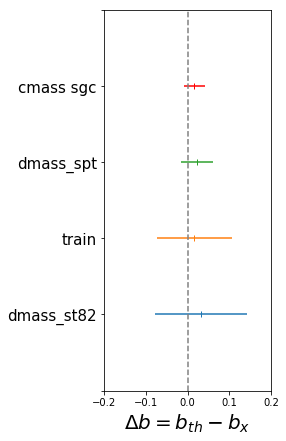

In [79]:
import scipy
theta_th, theory_sgc = np.loadtxt('../data_txt/acf_cmass_sgc_theory.txt', unpack=True)
theory_sgc_interp = scipy.interpolate.interp1d(theta_th, theory_sgc)
#theory_sgc_interp = theory_sgc_interp(meanr)

fig, ax = plt.subplots(figsize = (3,7))
brelsqr = np.linspace(0.5, 1.5, 5000) 
b_n = 2.0
brelarr = np.sqrt(brelsqr)
dbarray = b_n*(1-brelarr)
HF = lambda Nr,Nbin: (Nr-Nbin-2) *1./(Nr-1)
mock_num = 3

j = 1
catlist = [ 'dmass_st82', 'train','dmass_spt']
for name in catlist:
    
    filename = basedir+ 'acf_auto_'+name+'_nbins10_jk100.txt'
    covname = basedir+ 'acf_auto_'+name+'_nbins10_jk100.cov'
    #scalecut, scalecut2d = mask_scalecuts( meanrw)
    theory_interp = theory_sgc_interp(meanrw)
    cov_dmass_w = np.loadtxt( covname, unpack=True)
    HFd = HF(100, 10)
    #F_d = HFd * np.linalg.inv(cov_dmass_w[scalecut2d].reshape(n_remain,n_remain))
    F_d = HFd * np.linalg.inv(cov_dmass_w)
    #print xiw.shape, theory_interp.shape
    #print xiw[scalecut].shape, theory_interp[scalecut].shape, F_d.shape
    err_brelw, brelw, chisqr_resultw = brel_chisqr_fitting(xiw, theory_interp, F_d, verbose=True)   
    #ax.errorbar(2.-2*brelw, mock_num+1-j, xerr =err_brelw*2., fmt='-|', color='k')
    ax.errorbar(2. - 2*brelw, j, xerr =err_brelw*2., fmt='-|', label = name)
    j += 1
    
meanr_sgc, xi_sgc, xi_err_sgc = np.loadtxt('../data_txt//acf_auto_cmass_sgc_sys_cp_nz_weight_nbins10_jk100.txt',unpack=True)
cov_cmass_s = np.genfromtxt('../data_txt//acf_auto_cmass_sgc_sys_cp_nz_weight_nbins10_jk100.cov')
HFs = HF(100, 10)
F_s = HFs * np.linalg.inv(cov_cmass_s)
err_brelw, brelw, chisqr_resultw = brel_chisqr_fitting(xi_sgc, theory_sgc_interp(meanr_sgc), F_s, verbose=True)
ax.errorbar(2.- 2*brelw, j, xerr =err_brelw*2., fmt='-|', color='r', label = 'cmass sgc')
catlist = catlist + ['cmass sgc']
#ax.axvspan(- err_brelw*2, err_brelw*2.,  alpha=0.1, color='grey')
#ax.axvspan(- err_brelw*2, err_brelw*2.,  alpha=0.1, color='grey')
ax.axvline(x=0.0, color = 'grey', ls='--')
 
ax.set_xlabel(r'$\Delta b = b_{th} - b_x$', fontsize = 20)
#ax.set_ylabel(r'$\chi^2$')
#ax.legend(loc=1)
ax.set_xlim(-0.2, .2)
#ax.set_yticks([1,2,3,4,5,6,7,8,9,10,11,12])
ax.set_yticks(np.arange(len(catlist) + 2))
ax.set_yticklabels( [''] + catlist, fontsize = 15) 
fig.savefig(figoutdir + 'bias_weight.png')
print 'pic save to ', figoutdir + 'bias_weight.png'

In [14]:
kind = 'SPT'
FullArea = SPTMaparea
properties = ['GE']
#properties = ['DEPTH', 'EXPTIME', 'AIRMASS', 'SKYBRITE', 'FWHM', 'NSTARS_allband','GE']
suffix='no_weight'

In [20]:
# calculating galaxy density and weights iterately
sysMap = calling_sysMap( properties=properties, kind='SPT', nside=4096 )
#sysMap = adding_zpshift_to_sysmap(sysMap)
#sysMap = adding_residual_zpshift_sfd_to_sysmap(sysMap, kind='SPT')

In [15]:
# calculating galaxy density and weights iterately
sysMap_st82 = calling_sysMap( properties=properties, kind='STRIPE82', nside=4096 )
#sysMap_st82 = adding_zpshift_to_sysmap(sysMap_st82, kind='STRIPE82')
#sysMap_st82 = adding_residual_zpshift_sfd_to_sysmap(sysMap_st82, kind='STRIPE82')


# Corrected Colors vs. SFD98

In [167]:
dmass_masked = maskingCatalogSP(catalog=dmass, sysMap=sysMap)
rand_masked = maskingCatalogSP(catalog=rand, sysMap=sysMap)
rand2_masked = maskingCatalogSP(catalog=rand2, sysMap=sysMap)

KeyError: 'sys_EXPTIME_i_SPT'

# galaxy number density 

256

In [50]:
inputdir

'../output/sfd_train_photo_SamPle_full3_probcut005/'

../systematics.py:484: RuntimeWarning: invalid value encountered in divide
  Ngal_avg = Ngal *1./Nrand
../systematics.py:488: RuntimeWarning: divide by zero encountered in divide
  err = 1./np.sqrt(Ngal * w_FKP) * norm_galaxy_density
../systematics.py:488: RuntimeWarning: invalid value encountered in multiply
  err = 1./np.sqrt(Ngal * w_FKP) * norm_galaxy_density


saving data to  ../output/sfd_train_photo_SamPle_full2//sys/systematic_GE_g_STRIPE82_train.txt
saving fig to  ../output/sfd_train_photo_SamPle_full2//figure/systematic_GE_STRIPE82_train.png


0

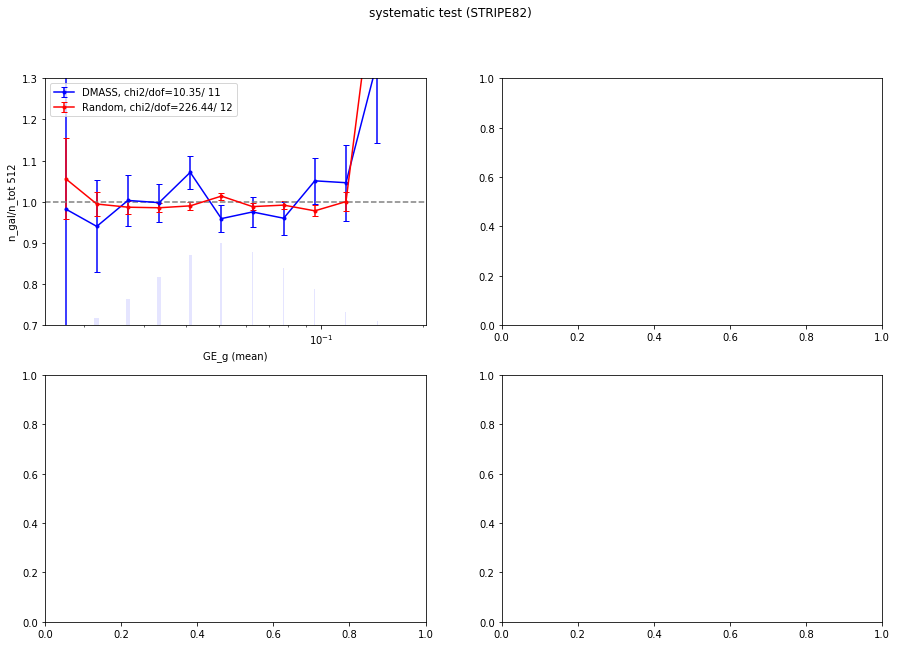

In [22]:
sys_ngal(cat1 = train, cat2=rand_cmass, rand1 = rand2_cmass, rand2 = rand2_cmass, 
         sysmap = sysMap_st82, 
         FullArea = ST82Maparea, properties = ['GE'], kind='STRIPE82', nbins =20, 
         reweight= None, nside = 512,
         suffix='train', outdir=sysoutdir)

from systematics_module.contCorrection import doVisualization_ngal
doVisualization_ngal(property = 'GE', nside = 512, kind = 'STRIPE82', suffix='train', \
                     inputdir=sysoutdir, outdir=figoutdir)



../systematics.py:531: RuntimeWarning: invalid value encountered in divide
  Ngal_avg = Ngal *1./Nrand
../systematics.py:535: RuntimeWarning: divide by zero encountered in divide
  err = 1./np.sqrt(Ngal * w_FKP) * norm_galaxy_density
../systematics.py:535: RuntimeWarning: invalid value encountered in multiply
  err = 1./np.sqrt(Ngal * w_FKP) * norm_galaxy_density


saving data to  ../output/slr_train_photo_SamPle_ran100//sys/systematic_GE_g_STRIPE82_dmass_st82.txt
saving fig to  ../output/slr_train_photo_SamPle_ran100//figure/systematic_GE_STRIPE82_dmass_st82.png


0

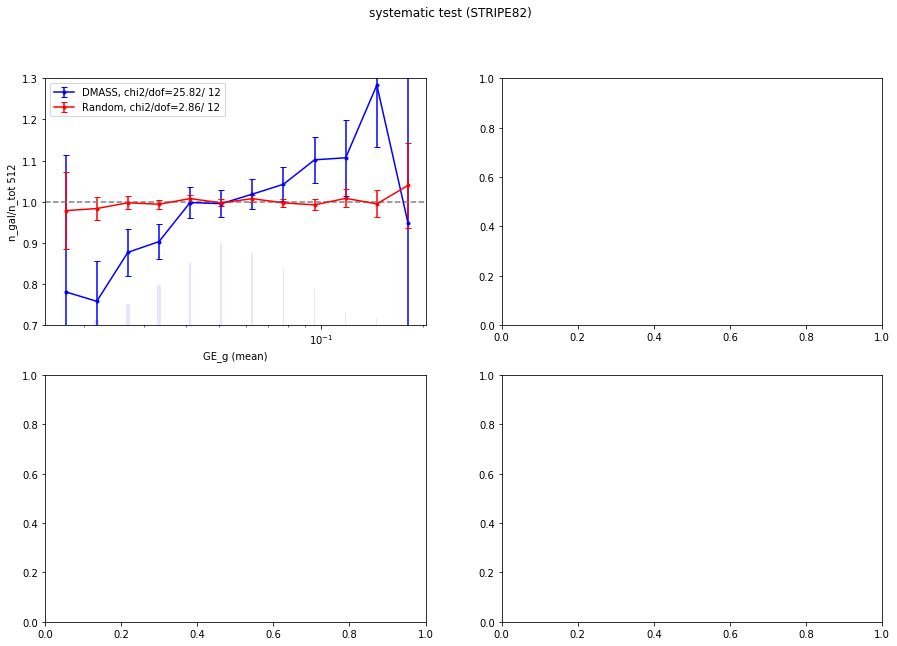

In [16]:
sys_ngal(cat1 = dmass_st82, cat2=rand_dmass_st82, rand1 = rand2_dmass_st82, rand2 = rand2_dmass_st82, 
         sysmap = sysMap_st82, 
         FullArea = ST82Maparea, properties = ['GE'], kind='STRIPE82', nbins =20, 
         reweight= None, nside = 512,
         suffix='dmass_st82', outdir=sysoutdir)

from systematics_module.contCorrection import doVisualization_ngal
doVisualization_ngal(property = 'GE', nside = 512, kind = 'STRIPE82', suffix='dmass_st82', \
                     inputdir=sysoutdir, outdir=figoutdir)



In [73]:
dmass_probcut = dmass[dmass['EachProb_CMASS'] > 0.1]

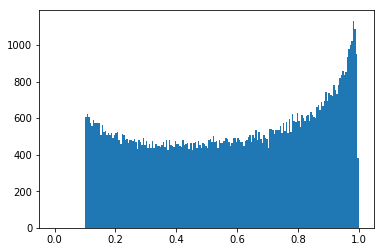

In [74]:
fig, ax = plt.subplots()
_ = ax.hist( dmass_probcut['EachProb_CMASS'], bins = np.linspace(0, 1, 201) )

saving data to  ../output/sfd_train_photo_SamPle_full3_probcut005//sys/systematic_GE_g_SPT_dmass_spt.txt
saving fig to  ../output/sfd_train_photo_SamPle_full3_probcut005//figure/systematic_GE_SPT_dmass_spt.png


0

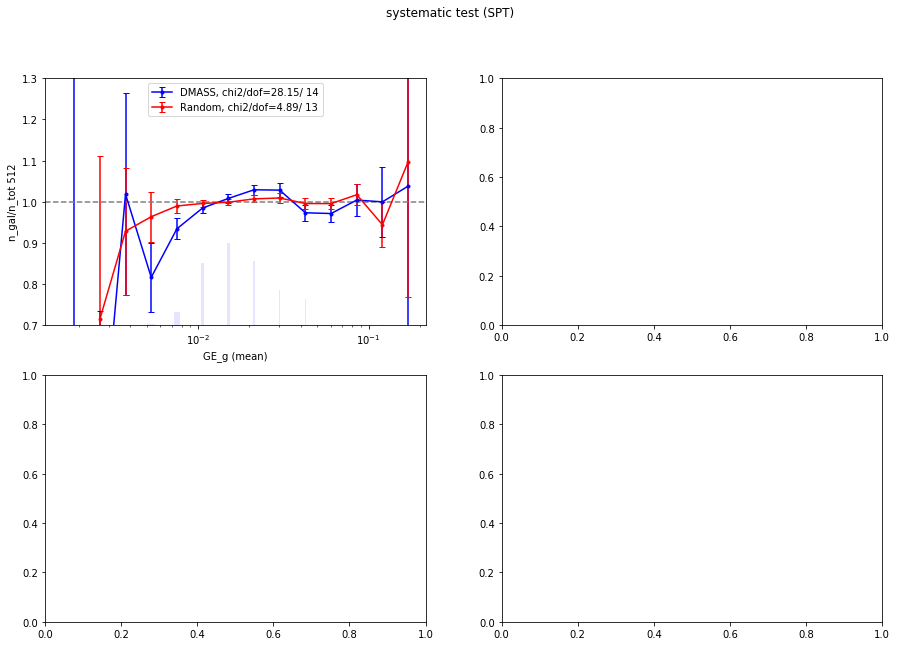

In [75]:
sys_ngal(cat1 = dmass_probcut, cat2=rand, rand1 = rand2, rand2 = rand2, 
         sysmap = sysMap, 
         FullArea = SPTMaparea, properties = ['GE'], kind='SPT', nbins =15, 
         reweight= None, nside = 512,
         suffix='dmass_spt', outdir=sysoutdir)

from systematics_module.contCorrection import doVisualization_ngal
doVisualization_ngal(property = 'GE', nside = 512, kind = 'SPT', suffix='dmass_spt', \
                     inputdir=sysoutdir, outdir=figoutdir)
